# Fish Detector

This notebook explores the images and trains a fish-detection model for the [Nature Conservancy Fisheries Competition](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring) hosted on Kaggle. This notebook assumes the following folder structure:

 - data
  - train (from Kaggle)
    - ALB
    - BET
    - ...
  - test_stg1 (from Kaggle)
  - [kaggleNatureConservancy](https://github.com/nathanie/kaggleNatureConservancy)
  - markers.csv
  - sample_submission_stg1.csv
  - train.csv (generated later)
 - models
  - \*.h5
 - shiny_annotater.R (for generating markers.csv)

We start with an exploration and then preparation of the dataset.

## Data Preparation

### Setup

import libraries

In [1]:
%matplotlib inline

# system libraries
import os
from glob import glob
import logging

# numerical,image and plotting stuff
import pandas as pd
import numpy as np
from PIL import Image
from skimage import io
import skimage.transform as tf
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid", {'axes.grid' : False})

### Files

The directory structure of this project places images in their labelled folders, which facilitates easy 're-labeling' just by moving files around. During the annotation phase, some 'mis-labeled' pictures were discovered and have been manually moved into different folders.

Let's begin by getting all the image file names and their associated classes from their latest location.

In [2]:
# get all image file names and associated class from their latest location
class_folders = glob('data/train/*')
files = [glob(cls + '/*') for cls in class_folders] # put class info with file name
files = [img for cls in files for img in cls]
df = pd.DataFrame({'fpath':files,'w':0,'h':0})
df['category'] = df.fpath.str.extract('data/train/([a-zA-Z]*)/img', expand=False) # extract class
df['fname'] = df.fpath.str.extract('data/train/[a-zA-Z]*/([a-zA-Z0-9_.]*)', expand=False) # extract file name
df.head()

fpath  h  w category          fname
0  data/train/ALB/img_00003.jpg  0  0      ALB  img_00003.jpg
1  data/train/ALB/img_00010.jpg  0  0      ALB  img_00010.jpg
2  data/train/ALB/img_00012.jpg  0  0      ALB  img_00012.jpg
3  data/train/ALB/img_00015.jpg  0  0      ALB  img_00015.jpg
4  data/train/ALB/img_00019.jpg  0  0      ALB  img_00019.jpg

### Dimensions

To get a feel for how large the pictures, we get the width and height of each picture, and plot their bi-variate distribution.

                 h            w
count  3777.000000  3777.000000
mean    755.656871  1281.985703
std      84.888042    53.990846
min     670.000000  1192.000000
25%     720.000000  1280.000000
50%     720.000000  1280.000000
75%     750.000000  1280.000000
max     974.000000  1732.000000


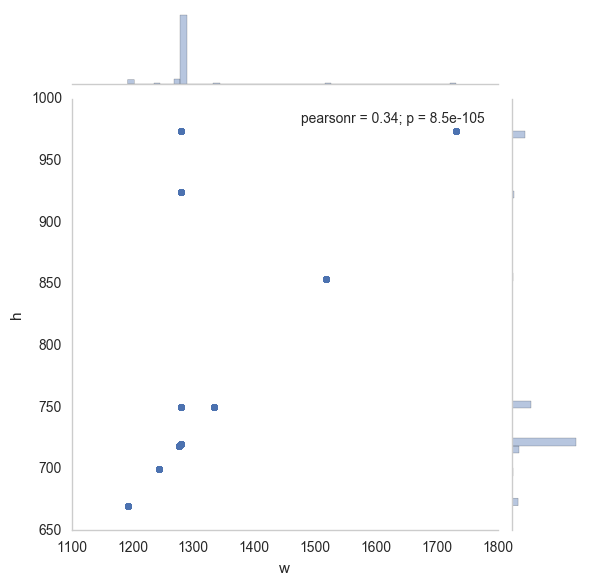

In [3]:
# get a distribution of w,h of all images ~4s for PIL's Image.open, 
# much longer for skimage.io.imread
for idx in df.index:
    im = Image.open(df.ix[idx].fpath)
    df.ix[idx,['w','h']] = im.size

df.to_csv('data/train.csv',index=False)
print(df.describe())
sns.jointplot(data=df,x='w',y='h',kind='scatter')

Height and width are approximately 720 x 1280. If we were to read all the files into memory, that would take up 3777 images \* 720 \* 1280 \* 3 = 10.4GB, which is not too much for modern computers. But to be memory-friendly and make this code accessible to others without the luxury of >= 16GB RAM, we'll write a generator to read in the files. Moreover, we would need a generator to perform various augmentations to our dataset to avoid over-fitting.

### Images

Let's see how the images look like with the following cell. If we re-run the following cell, we'll realize slowly that some of the pictures for the same class seem very similar, and could have been taken around the same time from the same camera from the same boat.

                                        fpath    h     w category  \
category                                                            
ALB      380     data/train/ALB/img_01753.jpg  720  1280      ALB   
BET      1921    data/train/BET/img_07734.jpg  720  1280      BET   
DOL      1977    data/train/DOL/img_02936.jpg  750  1280      DOL   
LAG      2090    data/train/LAG/img_06129.jpg  720  1280      LAG   
NoF      2555    data/train/NoF/img_07597.jpg  750  1334      NoF   
OTHER    2709  data/train/OTHER/img_03873.jpg  720  1280    OTHER   
SHARK    2913  data/train/SHARK/img_02169.jpg  750  1280    SHARK   
YFT      3302    data/train/YFT/img_02806.jpg  924  1280      YFT   

                       fname  
category                      
ALB      380   img_01753.jpg  
BET      1921  img_07734.jpg  
DOL      1977  img_02936.jpg  
LAG      2090  img_06129.jpg  
NoF      2555  img_07597.jpg  
OTHER    2709  img_03873.jpg  
SHARK    2913  img_02169.jpg  
YFT      3302  img_02806.jpg  

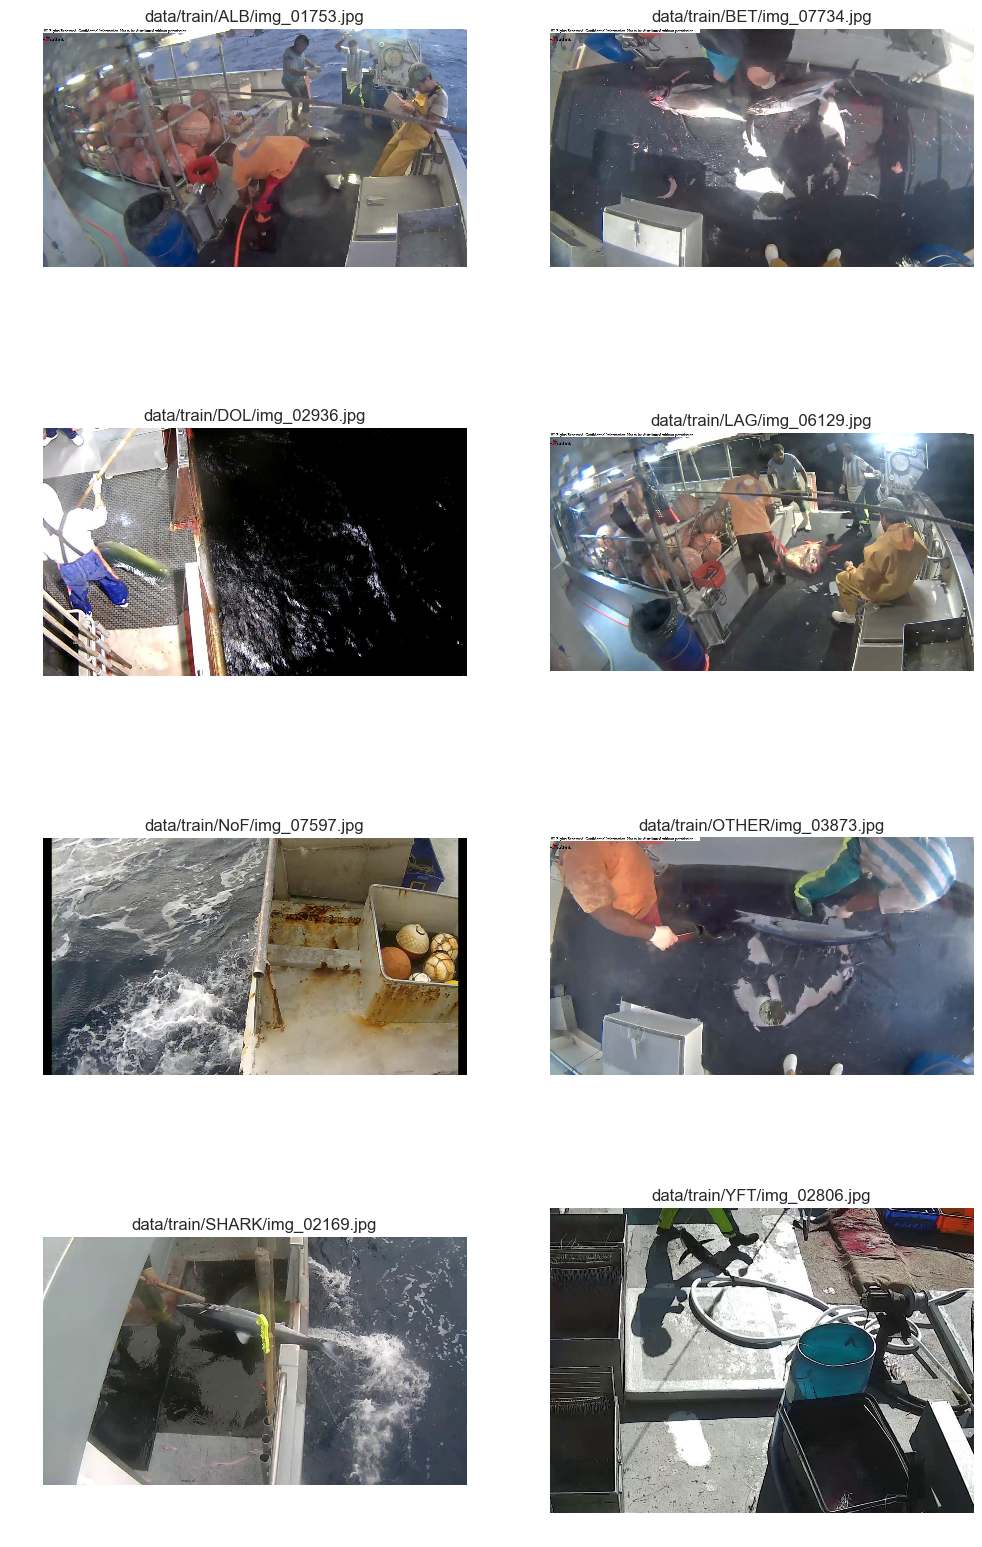

In [4]:
# sample an image per class of fish
fishes = df.groupby('category').apply(lambda x: x.sample(1))
print(fishes)
f = plt.figure(figsize=(12,20))
for i in range(len(fishes)):
    fpath = fishes.iloc[i]['fpath']
    img = io.imread(fpath)
    ax = plt.subplot(4,2,i+1)
    ax.imshow(img)
    ax.set_title(fpath)
    ax.axis('off')


### Annotations (Nathaniel's)

We read in all the annotations from [nathaniel's repository](https://github.com/nathanie/kaggleNatureConservancy) into a dataframe named `markers1`. The annotated json files should be in a folder titled `kaggleNatureConservancy` in the data folder.

As some of the annotations are just empty lists `[]` or lists of empty dictionaries `[{}]`, we perform some error handling to return `np.NaN` instead. We print out a list of the files without annotations as a simple sanity check.

In [5]:
f_json = glob('data/kaggleNatureConservancy/*.json')
markers1 = pd.DataFrame(columns=['annotations','class','filename'])
for i_json in f_json:
    print('reading %s' % i_json)
    i_markers = pd.read_json(i_json)
    markers1 = markers1.append(i_markers)

def split_annotations(an, default = (np.nan,np.nan,np.nan,np.nan)):
    try:
        return round(an[0]['x'],1), round(an[0]['y'],1), round(an[1]['x'],1), round(an[1]['y'],1)
    except KeyError:
        return default
    except IndexError:
        return default
    except Exception as e:
        print(e)
        return default

markers1['head_x'], markers1['head_y'], markers1['tail_x'], markers1['tail_y'] = \
    zip(* markers1['annotations'].map(split_annotations))
markers1 = markers1[['filename','head_x','head_y','tail_x','tail_y']]
print('\nfiles with missing labels:')
print(markers1[markers1['head_x'].isnull()])

reading data/kaggleNatureConservancy/alb_labels.json
reading data/kaggleNatureConservancy/bet_labels.json
reading data/kaggleNatureConservancy/dol_labels.json
reading data/kaggleNatureConservancy/lag_labels.json
reading data/kaggleNatureConservancy/other_labels.json
reading data/kaggleNatureConservancy/shark_labels.json
reading data/kaggleNatureConservancy/yft_labels.json

files with missing labels:
            filename  head_x  head_y  tail_x  tail_y
0         image2.jpg     NaN     NaN     NaN     NaN
112    img_00568.jpg     NaN     NaN     NaN     NaN
296    img_01354.jpg     NaN     NaN     NaN     NaN
316    img_01445.jpg     NaN     NaN     NaN     NaN
362    img_01660.jpg     NaN     NaN     NaN     NaN
701    img_03213.jpg     NaN     NaN     NaN     NaN
818    img_03694.jpg     NaN     NaN     NaN     NaN
903    img_04100.jpg     NaN     NaN     NaN     NaN
1364   img_06460.jpg     NaN     NaN     NaN     NaN
0     image00107.jpg     NaN     NaN     NaN     NaN
9      img_003

### Annotations (ours)

We read in our own annotations that is contained in `markers.csv`, then append it to the first set of annotations into a dataframe `markers`.

In [6]:
# read annotations 
markers2 = pd.read_csv('data/markers.csv')
markers2.head() 
# note the multiple annotations for the same image

filename  head_x  head_y  tail_x  tail_y
0  img_00003.jpg   314.4   377.4   595.5   191.4
1  img_00003.jpg   384.2   126.6   711.4   136.6
2  img_00003.jpg   675.6   108.4   982.3   171.5
3  img_00003.jpg   825.5   342.8  1095.1   449.4
4  img_00055.jpg   190.9   408.5   346.6   432.0

In [7]:
# combine annotations into a single data frame
markers = markers1.append(markers2)
markers = markers.sort_values(by=['filename','head_x','head_y','tail_x','tail_y'])
markers = markers.dropna()
markers.head(10)

filename  head_x  head_y  tail_x  tail_y
0     img_00003.jpg   314.4   377.4   595.5   191.4
1     img_00003.jpg   384.2   126.6   711.4   136.6
2     img_00003.jpg   675.6   108.4   982.3   171.5
1     img_00003.jpg   825.5   342.8  1095.1   449.4
3     img_00003.jpg   825.5   342.8  1095.1   449.4
1     img_00004.jpg   560.2   487.4   892.0   665.0
1832  img_00004.jpg   560.2   487.4   892.0   665.0
2335  img_00010.jpg   718.2   600.0   689.2   438.9
2     img_00010.jpg   721.6   606.1   688.1   433.6
2336  img_00010.jpg   846.0   407.3   910.7   319.3

As there are 'overlapping' annotations which are present in both datasets, but not exactly the same, we would need a simple function for de-duplicating them in each image. If the head and tail coords differ by less than a threshold (20px), we keep the first (nathaniel's) annotation. 

To prevent having to build a full cartesian product of all pairs of entries, we sort by the `filename` and the respective coordinate columns. Our task is then reduced to comparing adjacent records, which we achieve by adding a 1-shifted column that contains the previous row's coords :)

In [8]:
# add 1-shifted column of coordinates
markers['prev_head_x'] = markers.groupby('filename')['head_x'].shift()
markers['prev_tail_x'] = markers.groupby('filename')['tail_x'].shift()
markers['prev_head_y'] = markers.groupby('filename')['head_y'].shift()
markers['prev_tail_y'] = markers.groupby('filename')['tail_y'].shift()

def is_repeated(row,threshold=20):
    # if prev_head_x is na, it would be first coord in markers
    if np.isnan(row['prev_head_x']):
        return False
    else:
        diff_head_x = abs(row['head_x'] - row['prev_head_x'])
        diff_head_y = abs(row['head_y'] - row['prev_head_y'])
        diff_tail_x = abs(row['tail_x'] - row['prev_tail_x'])
        diff_tail_y = abs(row['tail_y'] - row['prev_tail_y'])
        if_similar = diff_head_x <= threshold and diff_head_y <= threshold and \
            diff_tail_x <= threshold and diff_tail_y <= threshold
        return if_similar

# see results
markers['is_repeated'] = markers.apply(is_repeated,axis=1)
markers

filename  head_x  head_y  tail_x  tail_y  prev_head_x  prev_tail_x  \
0     img_00003.jpg   314.4   377.4   595.5   191.4          NaN          NaN   
1     img_00003.jpg   384.2   126.6   711.4   136.6        314.4        595.5   
2     img_00003.jpg   675.6   108.4   982.3   171.5        384.2        711.4   
1     img_00003.jpg   825.5   342.8  1095.1   449.4        675.6        982.3   
3     img_00003.jpg   825.5   342.8  1095.1   449.4        825.5       1095.1   
1     img_00004.jpg   560.2   487.4   892.0   665.0          NaN          NaN   
1832  img_00004.jpg   560.2   487.4   892.0   665.0        560.2        892.0   
2335  img_00010.jpg   718.2   600.0   689.2   438.9          NaN          NaN   
2     img_00010.jpg   721.6   606.1   688.1   433.6        718.2        689.2   
2336  img_00010.jpg   846.0   407.3   910.7   319.3        721.6        688.1   
3     img_00012.jpg   492.2   514.0   602.7   681.4          NaN          NaN   
2337  img_00012.jpg   492.2   514.0   602.7   681.4        492.2        602.7   
2     img_00014.jpg   381.7   345.8   553.1   471.8          NaN          NaN   
1833  img_00014.jpg   381.7   345.8   553.1   471.8        381.7        553.1   
4     img_00015.jpg   258.0   359.6   435.7   396.2          NaN          NaN   
2338  img_00015.jpg   258.0   359.6   435.7   396.2        258.0        435.7   
5     img_00019.jpg   165.0   459.3   284.3   415.5          NaN          NaN   
2339  img_00019.jpg   165.0   459.3   284.3   415.5        165.0        284.3   
2340  img_00020.jpg   616.0   477.1   755.7   395.7          NaN          NaN   
2341  img_00020.jpg   636.4   716.3   701.2   528.6        616.0        755.7   
2342  img_00020.jpg   639.8   719.6   694.3   550.2        636.4        701.2   
2343  img_00020.jpg   656.9   423.9   728.4   350.9        639.8        694.3   
6     img_00020.jpg   712.9   675.2   800.3   491.0        656.9        728.4   
2344  img_00020.jpg   712.9   675.2   800.3   491.0        712.9        800.3   
2345  img_00020.jpg   714.8   676.4   823.8   487.1        712.9        800.3   
2346  img_00020.jpg   742.0   513.6   776.1   389.1        714.8        823.8   
2347  img_00020.jpg   803.4   460.5   837.5   347.5        742.0        776.1   
3     img_00021.jpg   891.1   620.4   885.5   414.5          NaN          NaN   
3779  img_00021.jpg   891.1   620.4   885.5   414.5        891.1        885.5   
4     img_00023.jpg   235.5   428.6   461.1   442.7          NaN          NaN   
...             ...     ...     ...     ...     ...          ...          ...   
3089  img_07892.jpg   271.0   166.0   574.0   102.0        271.0        574.0   
3090  img_07892.jpg   495.0   271.1   764.2   199.7        271.0        574.0   
117   img_07898.jpg   387.8   459.7   596.4   456.8          NaN          NaN   
4133  img_07898.jpg   387.8   459.7   596.4   456.8        387.8        596.4   
733   img_07901.jpg   108.6   393.4   382.1   427.2          NaN          NaN   
2333  img_07901.jpg   108.6   393.4   382.1   427.2        108.6        382.1   
1714  img_07903.jpg   647.0   472.0   724.0   381.0          NaN          NaN   
3091  img_07903.jpg   647.0   472.0   724.0   381.0        647.0        724.0   
1715  img_07904.jpg   148.4   499.9   163.9   644.8          NaN          NaN   
3092  img_07904.jpg   148.4   499.9   163.9   644.8        148.4        163.9   
734   img_07911.jpg   760.0   197.4  1129.4   204.5          NaN          NaN   
2334  img_07911.jpg   760.0   197.4  1129.4   204.5        760.0       1129.4   
1716  img_07912.jpg   396.0   288.0   565.0   140.0          NaN          NaN   
3093  img_07912.jpg   396.0   288.0   565.0   140.0        396.0        565.0   
1717  img_07914.jpg   358.6   261.2   561.7   325.4          NaN          NaN   
3094  img_07914.jpg   358.6   261.2   561.7   325.4        358.6        561.7   
3096  img_07915.jpg   161.0   503.7   147.4   631.6          NaN          NaN   
1718  img_07915.jpg   469.0   489.2   619.

Since the functions looks like it's working correctly, we do it on the `markers` data frame and drop the `prev_*` columns.

In [9]:
markers = markers.loc[(~markers['is_repeated']),\
                      ['filename','head_x','head_y','tail_x','tail_y']]

In [10]:
n_annotated = len(markers['filename'].unique())
n_total = len(df['fname'].unique())
n_NoF = len(df.loc[df['category']=='NoF','fname'].unique())

print('%d unique file names with >=1 annotation' % n_annotated)
print('%d file names in total' % n_total)
print('%d file names in NoF' % n_NoF)

3308 unique file names with >=1 annotation
3777 file names in total
470 file names in NoF


We perform a left join with the markers data frame to preserve the file names that do not have annotations.

In [11]:
df_full = pd.merge(left=df,right=markers,how='left',left_on='fname',right_on='filename')
print('df has %i rows' % len(df_full))
print(df_full.sample(10))

df has 4634 rows
                               fpath    h     w category          fname  \
3394  data/train/OTHER/img_05009.jpg  720  1280    OTHER  img_05009.jpg   
4567    data/train/YFT/img_07290.jpg  750  1280      YFT  img_07290.jpg   
1839    data/train/ALB/img_06286.jpg  720  1280      ALB  img_06286.jpg   
23      data/train/ALB/img_00041.jpg  720  1280      ALB  img_00041.jpg   
4055    data/train/YFT/img_02642.jpg  974  1280      YFT  img_02642.jpg   
2257    data/train/BET/img_00441.jpg  974  1280      BET  img_00441.jpg   
2074    data/train/ALB/img_07298.jpg  720  1280      ALB  img_07298.jpg   
269     data/train/ALB/img_00747.jpg  924  1280      ALB  img_00747.jpg   
90      data/train/ALB/img_00248.jpg  974  1280      ALB  img_00248.jpg   
2764    data/train/NoF/img_00481.jpg  670  1192      NoF  img_00481.jpg   

           filename  head_x  head_y  tail_x  tail_y  
3394  img_05009.jpg   984.0   231.3   740.3   208.0  
4567  img_07290.jpg   760.0   737.4   387.8   617

As not all the images have been fully annotated, we'll take away those that have not been verified to have multiple annotations fully accounted for. The updated list is in the repository's README. 

Note we include the NoF images (which we assume to have none of the fishes of interest) but exclude the unverified ranges.

If all images can be verified, then we do not need this exclusion.

In [12]:
valid_range = list(range(826)) + list(range(1714,1840)) + list(range(1925,2800)) + \
    list(range(2869,2960)) + list(range(3044,3346))
valid_fname = markers2.ix[valid_range,'filename']
print('%d valid images' % len(valid_fname))

2220 valid images


In [13]:
df_full = df_full.ix[df_full.filename.isin(valid_fname)]
print('%d entries to be used' % len(df_full))
df_full.to_csv('data/train.csv', index=False, float_format='%.1f')

2242 entries to be used


We sample images and check the annotations to see that they are reasonably labeled and do not have missing annotations.

Note the head and tail coordinates have not been normalized (just raw pixel position).

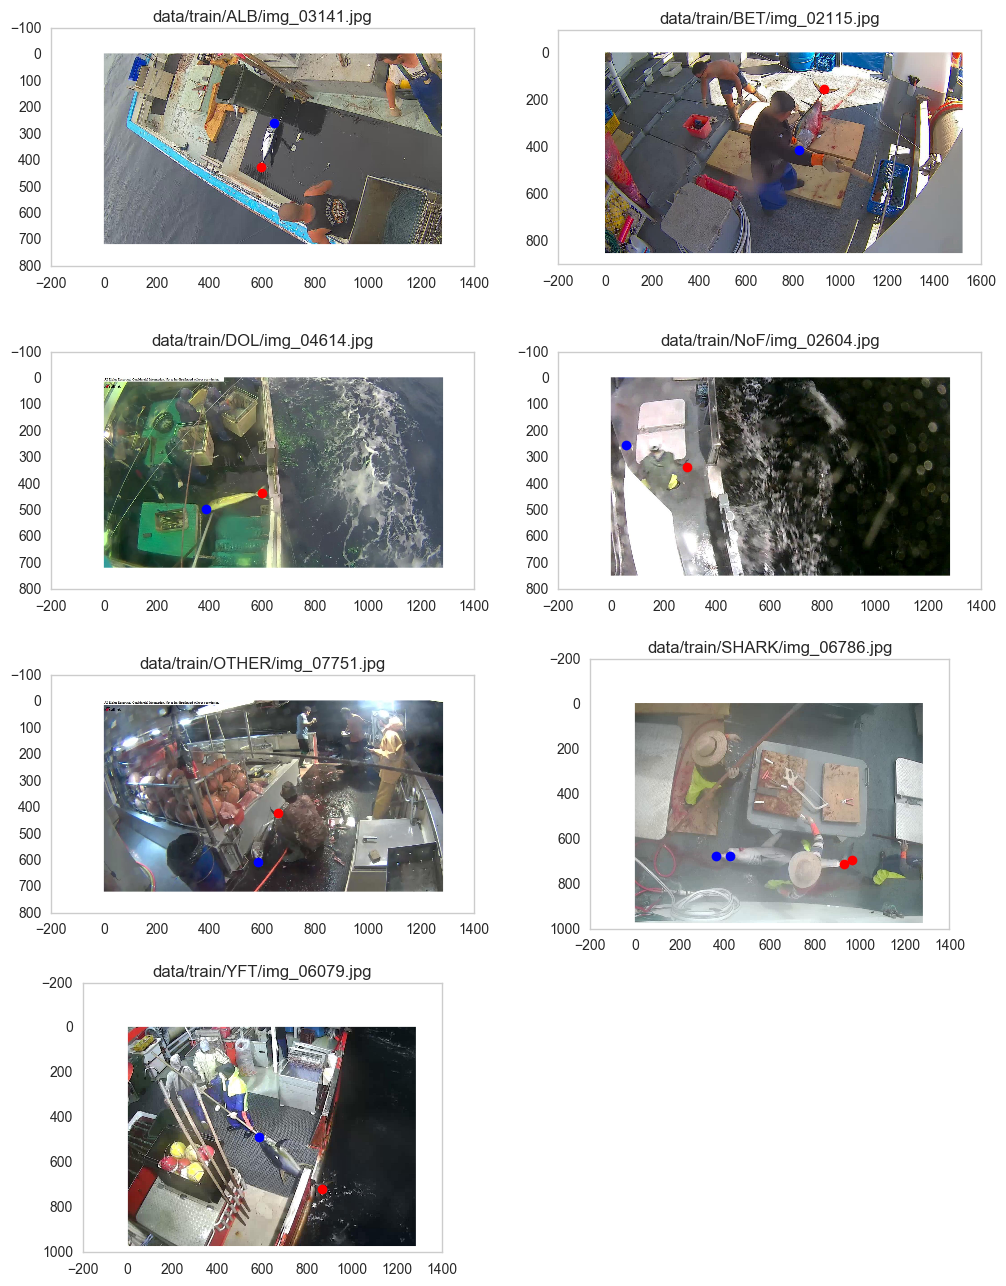

In [14]:
# sample an image per class of fish
fishes = df_full.groupby('category').apply(lambda x: x.sample(1))
f = plt.figure(figsize=(12,16))
for i in range(len(fishes)):
    # get image path
    fpath = fishes.iloc[i]['fpath']
    fname = fishes.iloc[i]['fname']
    img = io.imread(fpath)
    # get all annotations for that image
    anno = df_full.loc[df_full['fname']==fname,['head_x','head_y','tail_x','tail_y']]
    head_x, head_y, tail_x, tail_y = \
    np.array(anno['head_x'],dtype='int'), np.array(anno['head_y'],dtype='int'),\
    np.array(anno['tail_x'],dtype='int'), np.array(anno['tail_y'],dtype='int')
    ax = plt.subplot(4,2,i+1)
    ax.imshow(img)
    ax.set_title(fpath)
    ax.plot(head_x,head_y,'bo')
    ax.plot(tail_x,tail_y,'ro')



Before we start training our model, we need a few things:
 - Data Generator (train, valid, test, with augmentation)
 - Model Specification and weights (borrowed from [here](https://github.com/fchollet/deep-learning-models))

## Data Generator

Given the small amount of data provided, and the correlated nature of some of these images (from the same video camera on the same boat), we need to heavily augment the data provided to prevent our model from 'memorising' the extraneous features, such as the boat, fishermen, etc. We will use:
 - horizontal/vertical flips (TODO)
 - +-15% rotations
 - crops
 - chance of occluding the fish and switching the label to 'NoF'
 - chance of blurring the fish while preserving the label

To make the generator generalizable to both coordinate and detection predictions, we use a `return_type` and `p_remove` parameters to denote the type to return, and the probability of occlusion. We do not want any occlusion of the single fish kept for the `return_type` of `coord`, and so `p_remove` should be set to 0.

(144, 256, 3) 0


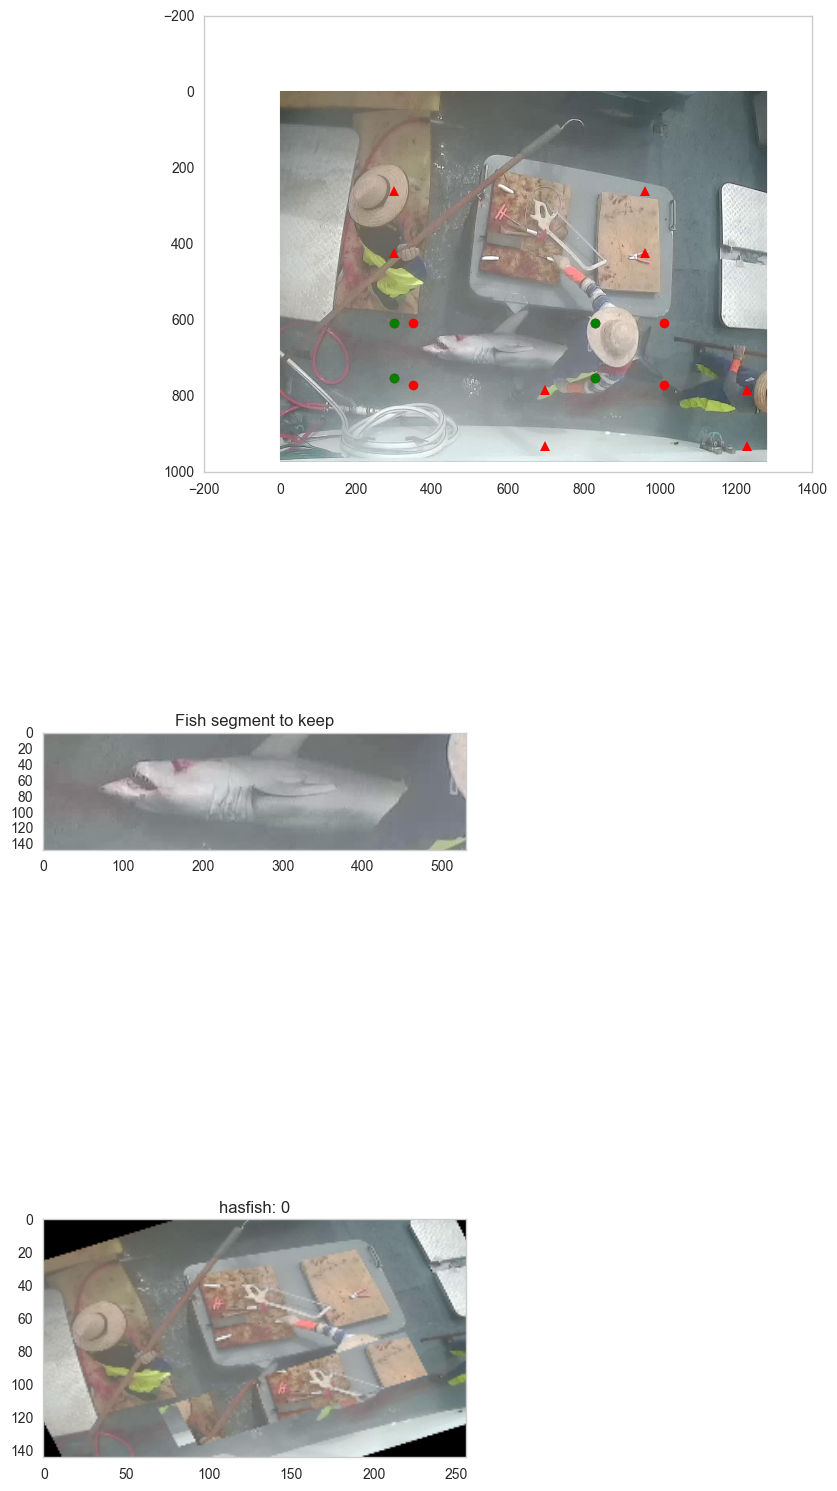

In [15]:
# helper functions

# takes a bounding box and checks if contains any of the annotated marks are inside
def contains(bbox,df_marks,bounding_buffer=30):
    x_min,x_max,y_min,y_max = bbox
    x_mins = df_marks.loc[:,['head_x','tail_x']].min(axis=1)
    x_maxs = df_marks.loc[:,['head_x','tail_x']].max(axis=1)
    y_mins = df_marks.loc[:,['head_y','tail_y']].min(axis=1)
    y_maxs = df_marks.loc[:,['head_y','tail_y']].max(axis=1)
    conds = ~((x_mins + bounding_buffer > x_min) & (x_maxs - bounding_buffer < x_max) \
              & (y_mins + bounding_buffer > y_min) & (y_maxs - bounding_buffer < y_max))
    return ~(conds.all())

# convenience function for bounding values within a max and min value (to prevent under/over-indexing the image)
def bound(val,val_max,val_min):
    return max(min(val,val_max),val_min)

# performs various distortions to the image and the corresponding annotated label, coords
def augment(df_marks,return_type,rng,p_remove=0.5,buffer_x_pct=0.15,buffer_y_pct=0.15,
           buffer_x_min=70,buffer_y_min=70,w_out=256,h_out=144,if_plot=False):
    fpath = df_marks['fpath'].iloc[0]
    img = io.imread(fpath)
    h_img, w_img, ch_img = img.shape
    if if_plot:
        f = plt.figure(figsize=(12,20))
        plt.subplot(311)
        plt.imshow(img)
    # get category (if a fish is present or not)
    category = df_marks.iloc[0]['category']
    hasfish = 0 if category=='NoF' else 1

    # if fish present, perform occlusion
    if hasfish:
        if return_type == 'contain' and rng.rand() < p_remove:
            # swap label, occlude all fish annotations with random part
            hasfish = 0
        # else keep 1 random fish annotation, and occlude all other fishes
        indices = rng.permutation(df_marks.index)
        i_keep = indices[0] # take the first amongst the shuffled fish indices
        for ix in indices:
            # get inner bounding box
            x_min = bound(int(min(df_marks.loc[ix,'head_x'],df_marks.loc[ix,'tail_x'])),w_img,0)
            x_max = bound(int(max(df_marks.loc[ix,'head_x'],df_marks.loc[ix,'tail_x'])),w_img,0)
            y_min = bound(int(min(df_marks.loc[ix,'head_y'],df_marks.loc[ix,'tail_y'])),h_img,0)
            y_max = bound(int(max(df_marks.loc[ix,'head_y'],df_marks.loc[ix,'tail_y'])),h_img,0)
            # expand bounding box
            h_box, w_box = y_max - y_min, x_max - x_min
            buffer_x = int(max(buffer_x_min,w_box * buffer_x_pct))
            buffer_y = int(max(buffer_y_min,h_box * buffer_y_pct))
            x_min = bound(x_min - buffer_x, w_img, 0)
            y_min = bound(y_min - buffer_y, h_img, 0)
            x_max = bound(x_max + buffer_x, w_img, 0)
            y_max = bound(y_max + buffer_y, h_img, 0)
            if if_plot:
                plt.plot(x_min,y_min,'ro')
                plt.plot(x_min,y_max,'ro')
                plt.plot(x_max,y_min,'ro')
                plt.plot(x_max,y_max,'ro')
            h_box, w_box = y_max - y_min, x_max - x_min
            assert(h_box > 0 and w_box > 0)
            # if keep, make a copy of the fish in the original position, store in keep
            if ix == i_keep:
                if if_plot:
                    plt.plot(x_min,y_min,'go')
                    plt.plot(x_min,y_max,'go')
                    plt.plot(x_max,y_min,'go')
                    plt.plot(x_max,y_max,'go')
                # our annotated values need not be bounded between 0 to w or h, 
                # as we want to be able to preserve the proportions of the fish when cropping
                x_head = int(df_marks.loc[ix,'head_x'])
                x_tail = int(df_marks.loc[ix,'tail_x'])
                y_head = int(df_marks.loc[ix,'head_y'])
                y_tail = int(df_marks.loc[ix,'tail_y'])
                keep = img[y_min:y_max,x_min:x_max,:].copy()
                if if_plot:
                    plt.subplot(323)
                    plt.imshow(keep)
                    plt.title('Fish segment to keep')
                    plt.subplot(311)
                x_keep_min, y_keep_min = x_min, y_min
                h_keep, w_keep = h_box, w_box
            # get another random box of a similar size that doesn't contain a fish
            x_swap_min = int(rng.uniform(0,w_img-w_box,1))
            y_swap_min = int(rng.uniform(0,h_img-h_box,1))
            x_swap_max = x_swap_min + w_box
            y_swap_max = y_swap_min + h_box
            bbox = (x_swap_min,x_swap_max,y_swap_min,y_swap_max)
            while contains(bbox,df_marks):
                x_swap_min = int(rng.uniform(0,w_img-w_box,1))
                y_swap_min = int(rng.uniform(0,h_img-h_box,1))
                x_swap_max = x_swap_min + w_box
                y_swap_max = y_swap_min + h_box
                bbox = (x_swap_min,x_swap_max,y_swap_min,y_swap_max)
            if if_plot:
                plt.plot(x_swap_min,y_swap_min,'r^')
                plt.plot(x_swap_min,y_swap_min+h_box,'r^')
                plt.plot(x_swap_min+w_box,y_swap_min,'r^')
                plt.plot(x_swap_min+w_box,y_swap_min+h_box,'r^')
            # copy over random box
            random_box = img[y_swap_min:(y_swap_min+h_box),
                x_swap_min:(x_swap_min+w_box),:].copy()
            img[y_min:y_max,x_min:x_max,:] = random_box
        # put a fish back in a random position
        if hasfish:
            if if_plot:
                plt.plot(x_head,y_head,'yo')
                plt.plot(x_tail,y_tail,'yo')
                plt.plot(x_head,y_head,'yo')
                plt.plot(x_tail,y_tail,'yo')
            x_swap_min = int(rng.uniform(0,w_img-w_keep,1))
            y_swap_min = int(rng.uniform(0,h_img-h_keep,1))
            x_diff = x_swap_min - x_keep_min
            y_diff = y_swap_min - y_keep_min
            x_head = x_head + x_diff
            x_tail = x_tail + x_diff
            y_head = y_head + y_diff
            y_tail = y_tail + y_diff
            if if_plot:
                plt.plot(x_head,y_head,'yo')
                plt.plot(x_tail,y_tail,'yo')
                plt.plot(x_head,y_head,'yo')
                plt.plot(x_tail,y_tail,'yo')
            img[y_swap_min:(y_swap_min+h_keep), \
                x_swap_min:(x_swap_min+w_keep),:] = keep
            if if_plot:
                plt.subplot(324)
                plt.imshow(img)
                plt.plot(x_swap_min,y_swap_min,'bo')
                plt.plot(x_swap_min,y_swap_min+h_keep,'bo')
                plt.plot(x_swap_min+w_keep,y_swap_min,'bo')
                plt.plot(x_swap_min+w_keep,y_swap_min+h_keep,'bo')
            
    
    # perform affine transformations
    r_tx, r_ty = rng.normal(w_img/2,50,1)[0], rng.normal(h_img/2,50,1)[0]
    r_tx = 0 if r_tx < 0 else w_img if r_tx > w_img else int(r_tx)
    r_ty = 0 if r_ty < 0 else h_img if r_ty > h_img else int(r_ty)
    r_rotate = rng.uniform(-np.pi/6,np.pi/6,1)[0]
    tf_rotate = tf.SimilarityTransform(rotation=r_rotate)
    tf_scale = tf.SimilarityTransform(scale=rng.uniform(0.8,1.5,1))
    tf_shear = tf.AffineTransform(shear=rng.uniform(-0.1,0.1,1))
    tf_shift = tf.SimilarityTransform(translation=[-r_tx, -r_ty])
    tf_shift_inv = tf.SimilarityTransform(translation=[r_tx, r_ty])
    trans = tf_shift + tf_scale + tf_shear + tf_rotate + tf_shift_inv

    img_warped = tf.warp(img, trans.inverse)
    img_final = tf.resize(img_warped,(h_out,w_out))

    if return_type == 'coord':
        head = np.matmul(trans.params[:2,:],np.array([x_head,y_head,1]))
        tail = np.matmul(trans.params[:2,:],np.array([x_tail,y_tail,1]))
        # rescale coordinates to output shape
        head[0] = head[0] / w_img * w_out
        head[1] = head[1] / h_img * h_out
        tail[0] = tail[0] / w_img * w_out
        tail[1] = tail[1] / h_img * h_out
        
    if if_plot:
        plt.subplot(325)
        plt.title('hasfish: %d' % hasfish)
        plt.imshow(img_final)
        if return_type == 'coord':
            plt.plot(head[0],head[1],'go')
            plt.plot(tail[0],tail[1],'bo')
    
    if return_type == 'contain':
        return img_final, hasfish
    elif return_type == 'coord':
        return img_final, np.array([head[0],head[1],tail[0],tail[1]])
    else:
        print('Unexpected return type %s. Please specify "contain" or "coord".' % return_type)

fpath = df_full.fpath.sample(n=1).iloc[0]
fpath = 'data/train/SHARK/img_06410.jpg'
df_marks = df_full.loc[df_full['fpath']==fpath]
im,hasfish = augment(df_marks,'contain',np.random.RandomState(2),if_plot=True)
print(im.shape,hasfish)

In [16]:
# this function encodes and decodes an augmented input of (X,Y), where
# X is (batch_size,h,w,ch)
# Y is (batch_size,4)
# Y encoded for regression becomes [1D,1D,1D,1D], where 1D is scaled between -1 to +1
# Y encoded for classification becomes [2D,2D,2D,2D], where 2D is one-hot encoded

def encode_regression(Y,h=144,w=256):
    x_head = Y[:,0]/w*2-1
    y_head = Y[:,1]/h*2-1
    x_tail = Y[:,2]/w*2-1
    y_tail = Y[:,3]/h*2-1
    return [x_head,y_head,x_tail,y_tail]

def decode_regression(Y,h=144,w=256):
    batch_size = len(Y[0])
    Yd = np.zeros((batch_size,4))
    for i in range(len(Y)):
        if i % 2 == 0: # x coord
            Yd[:,i] = (Y[i]+1)/2*w
        else: # y coord
            Yd[:,i] = (Y[i]+1)/2*h
    return Yd

from sklearn.preprocessing import OneHotEncoder
enc_x = OneHotEncoder(sparse=False)
enc_y = OneHotEncoder(sparse=False)

def encode_classification(Y,h_in=144,w_in=256,h_out=36,w_out=64):
    batch_size = Y.shape[0]
    x_head = np.int16(np.clip(Y[:,0],0,w_in-1) / w_in * w_out).reshape(batch_size,1)
    y_head = np.int16(np.clip(Y[:,1],0,h_in-1) / h_in * h_out).reshape(batch_size,1)
    x_tail = np.int16(np.clip(Y[:,2],0,w_in-1) / w_in * w_out).reshape(batch_size,1)
    y_tail = np.int16(np.clip(Y[:,3],0,h_in-1) / h_in * h_out).reshape(batch_size,1)
    enc_x.fit(np.arange(w_out).reshape(w_out,1))
    enc_y.fit(np.arange(h_out).reshape(h_out,1))
    x_head = enc_x.transform(x_head)
    y_head = enc_y.transform(y_head)
    x_tail = enc_x.transform(x_tail)
    y_tail = enc_y.transform(y_tail)
    return [x_head,y_head,x_tail,y_tail]

def decode_classification(Y,h_in=144,w_in=256,h_out=36,w_out=64):
    batch_size = len(Y[0])
    Yd = np.zeros((batch_size,4))
    for i in range(len(Y)):
        if i % 2 == 0: # x coord
            Yd[:,i] = np.argmax(Y[i],axis=1)/w_out*w_in
        else: # y coord
            Yd[:,i] = np.argmax(Y[i],axis=1)/h_out*h_in
    return Yd

In [17]:

def gen(df_gen, return_type='contain', encode_type='classification', batch_size=32, \
        rng=None, h=144, w=256, ch=3, h_out=36, w_out=64):
    """
    This generator produces a batch of (X,y) for training a fish detector.
    Images are randomly augmented.
    
    Inputs:
    df_gen is a pandas dataframe containing the file path (fpath), 
    potentially multiple head and tail annotations
    return_type is string of either 'contain' or 'coord'
    
    Outputs:
    X is a 4D tensor of shape (batch_size,h,w,ch)
    if return_type is 'contain'
        y is a binary vector with 1 if the image has a fish else 0
    else
        y is a 2D vector of (batch_size,4), with the 2 pairs of coordinates
    """
    if return_type not in ['contain','coord']:
        raise ValueError('Invalid return type %s' % return_type)
    if encode_type not in ['regression','classification']:
        raise ValueError('Invalid encode type %s' % encode_type)
    if rng is None:
        rng = np.random.RandomState(241016)
    fishes = df_gen['fpath'].unique()
    n = len(fishes)
    total_batch = int(np.ceil(n / batch_size))
    logging.info('generating %d batches with %d samples per epoch' % (total_batch,n))
    
    while True:
        # shuffle examples every epoch
        fishes_shuffled = fishes[rng.permutation(n)]
        for i_batch in range(total_batch):
            # limit end index by size of df_gen to prevent 
            # indexing up to the next multiple of batch_size
            i_start, i_end = i_batch * batch_size, min((i_batch + 1) * batch_size,n)
            i_batch_size = i_end - i_start
            X = np.zeros((i_batch_size,h,w,ch))
            if return_type == 'contain':
                Y = np.zeros(i_batch_size)
            else:
                Y = np.zeros((i_batch_size,4))
            for i_fish in range(i_start,i_end):
                i_fpath = fishes_shuffled[i_fish]
                df_marks = df_gen.loc[df_gen['fpath']==i_fpath]
                x,y = augment(df_marks,return_type,rng) # augment image
                i_intrabatch = i_fish - i_start
                X[i_intrabatch,:] = x
                Y[i_intrabatch] = y
            logging.info('yielding batch %d of size %d' % (i_batch, i_batch_size))
            if return_type == 'contain':
                yield(X,Y)
            else:
                if encode_type == 'regression':
                    Y = encode_regression(Y,h=h,w=w)
                elif encode_type == 'classification':
                    Y = encode_classification(Y,h_in=h,w_in=w,h_out=h_out,w_out=w_out)
                yield (X,Y)

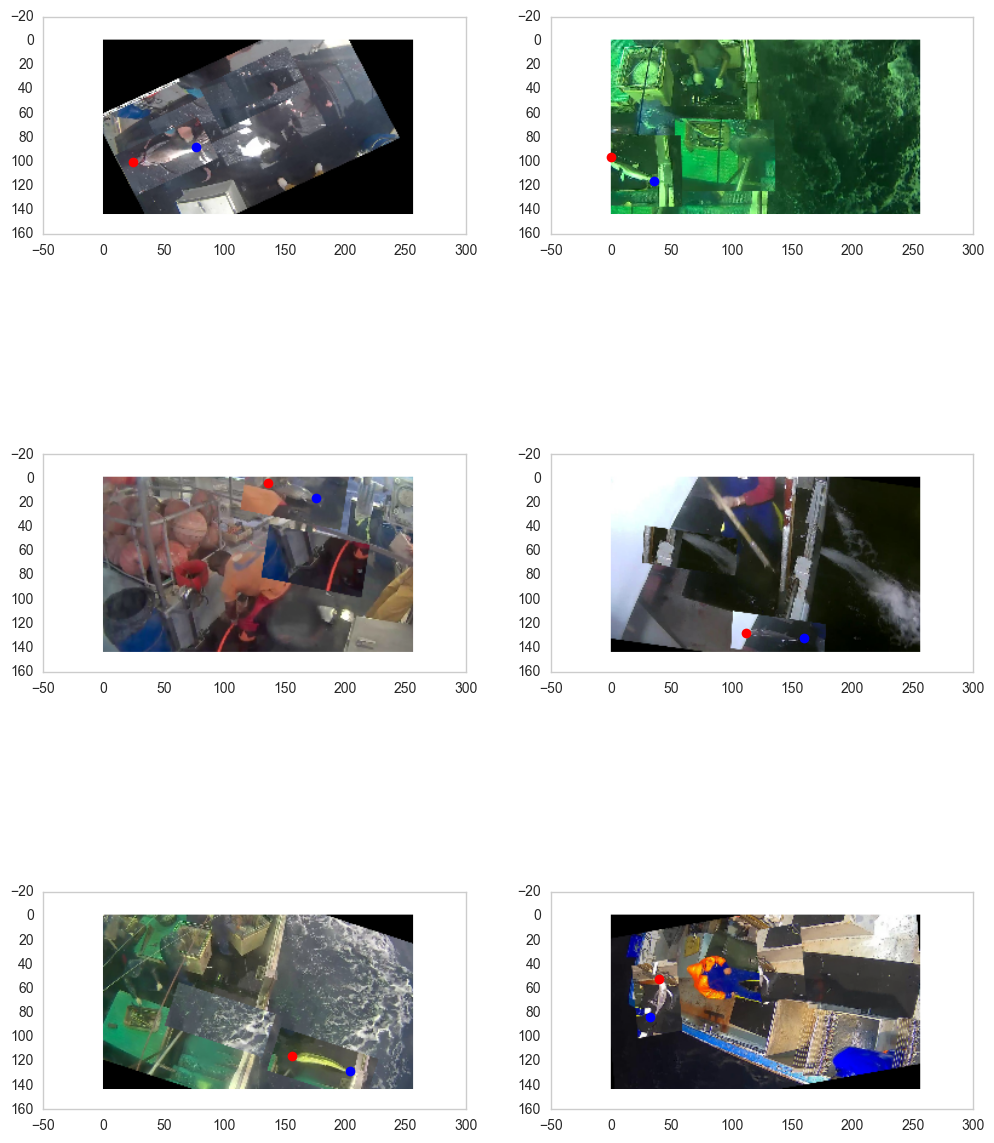

In [18]:
# visual test for classification: generate a batch of 6 and print the plots
bs = 6
gen_train = gen(df_full[df_full['category'] != 'NoF'],'coord','classification',6,np.random.RandomState(0))
X,Y = next(gen_train)
Y = decode_classification(Y)
plt.figure(figsize=(12,16))
for i in range(bs):
    plt.subplot('32'+str(i+1))
    plt.imshow(X[i,...])
    if len(Y) > 1: # coord
        plt.plot(Y[i,0],Y[i,1],'ro')
        plt.plot(Y[i,2],Y[i,3],'bo')
    else: # contain
        plt.title(Y[i])

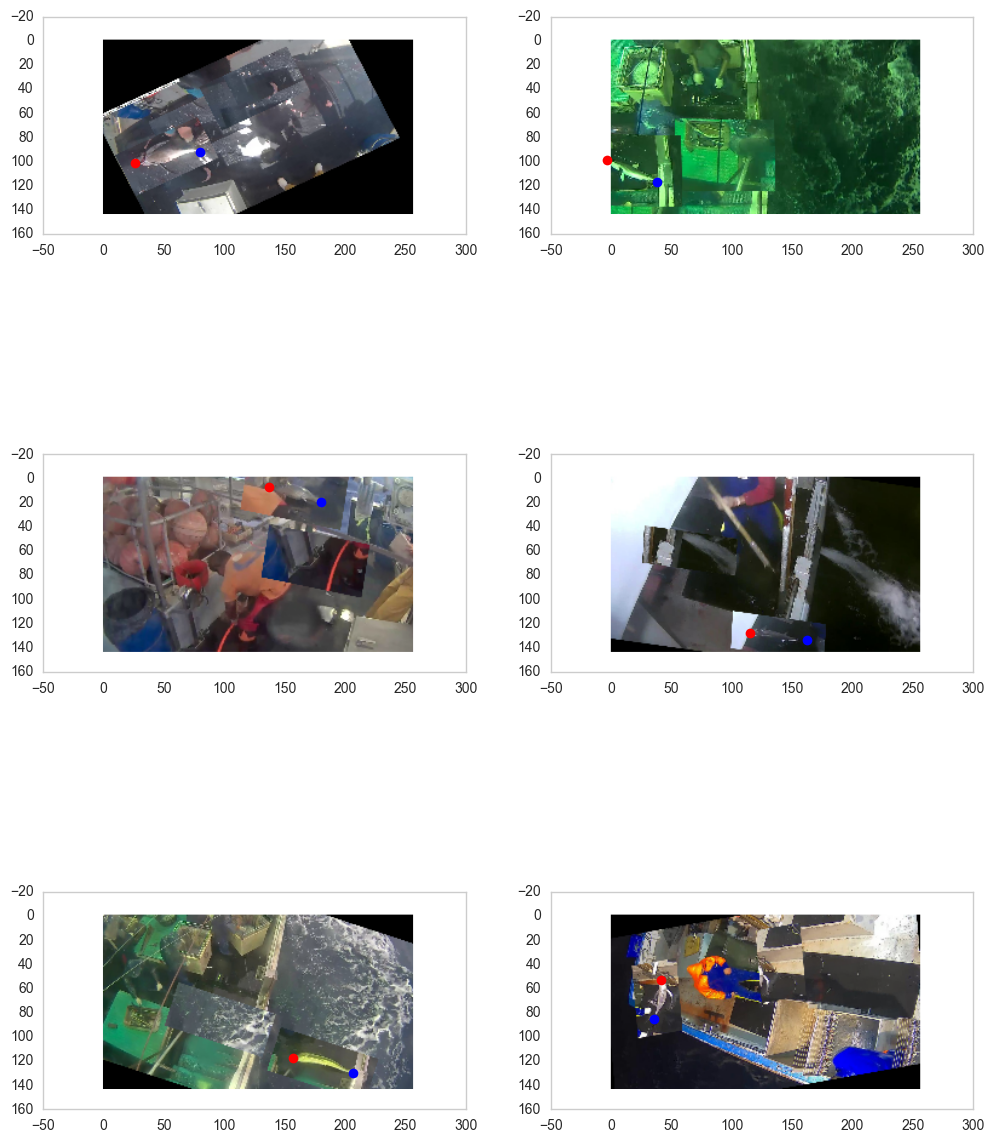

In [19]:
# visual test for regression: generate a batch of 6 and print the plots
bs = 6
gen_train = gen(df_full[df_full['category'] != 'NoF'],'coord','regression',6,np.random.RandomState(0))
X,Y = next(gen_train)
Y = decode_regression(Y,h=144,w=256)
plt.figure(figsize=(12,16))
for i in range(bs):
    plt.subplot('32'+str(i+1))
    plt.imshow(X[i,...])
    if len(Y) > 1: # coord
        plt.plot(Y[i,0],Y[i,1],'ro')
        plt.plot(Y[i,2],Y[i,3],'bo')
    else: # contain
        plt.title(Y[i])


Having built a reliable generator for supplying a stream of augmented images that can produce both binary responses (1 if a fish is present) and real-valued coordinates, we move on to define a model that will consume these augmented images to predict whether the image contains a fish (as a first cut benchmark).

## Model Definition

We begin with a VGG16-like network, inspired by this [previous kaggle competition winner](https://deepsense.io/deep-learning-right-whale-recognition-kaggle/). We prefer the tensorflow backend here, due to the convenience of its image ordering (h,w,ch) as opposed to (ch,h,w), which allows us to plot the pictures directly when debugging. Given some success with another experimented architecture, we will implement it here.

In [30]:
from keras.layers import Input, Convolution2D, MaxPooling2D, ZeroPadding2D, Layer
from keras.layers import Activation, Dropout, Flatten, MaxoutDense, Dense
from keras.models import Model
from keras.optimizers import SGD, RMSprop
from keras import backend as K


# custom layer for getting max for over each vertical strip
class VerticalMax(Layer):
    def get_output_shape_for(self, input_shape):
        shape = list(input_shape)
        assert len(shape) == 4  # only valid for 4D tensors (batch_size,h,w,ch)
        return (input_shape[0],input_shape[2],input_shape[3]) # (batch_size,w,ch)

    def call(self, x, mask=None):
        return K.max(x, axis=1, keepdims=False)

    
# custom layer for getting max for over each horizontal strip
class HorizontalMax(Layer):
    def get_output_shape_for(self, input_shape):
        shape = list(input_shape)
        assert len(shape) == 4  # only valid for 4D tensors (batch_size,h,w,ch)
        return (input_shape[0],input_shape[1],input_shape[3]) # (batch_size,h,ch)

    def call(self, x, mask=None):
        return K.max(x, axis=2, keepdims=False)

# returns a model
def new_model(return_type='coord',encode_type='classification', 
              h_in=144, w_in=256, h_out=36, w_out=64 ,ch=3):
    
    if return_type not in ['contain','coord']:
        raise ValueError('Invalid return type %s' % return_type)
    if encode_type not in ['regression','classification']:
        raise ValueError('Invalid encode type %s' % encode_type)
        
    image_input = Input(shape=(h_in,w_in,ch))
    block1 = ZeroPadding2D((1,1))(image_input)
    block1 = Convolution2D(16,3,3,activation='relu',name='conv1')(block1)
    block1 = MaxPooling2D((2,2),strides=(2,2))(block1)

    block2 = ZeroPadding2D((1,1))(block1)
    block2 = Convolution2D(32,3,3,activation='relu',name='conv2')(block2)
    block2 = MaxPooling2D((2,2),strides=(2,2))(block2)

    block3 = ZeroPadding2D((1,1))(block2)
    block3 = Convolution2D(64,3,3,activation='relu',name='conv3')(block3)
#     block3 = ZeroPadding2D((1,1))(block2)
#     block3 = Convolution2D(64,3,3,activation='relu',name='conv3')(block3)
    block3 = MaxPooling2D((2,2),strides=(2,2))(block3)

    block4 = ZeroPadding2D((1,1))(block3)
    block4 = Convolution2D(64,3,3,activation='relu',name='conv4')(block4)
    block4 = MaxPooling2D((2,2),strides=(2,2))(block4)

    # block5 = ZeroPadding2D((1,1))(block4)
    # block5 = Convolution2D(32,3,3,activation='relu',name='conv5')(block5)
    # block5 = MaxPooling2D((2,2),strides=(2,2))(block5)

    final = block4


    if return_type == 'coord':
        # x_head_pool = VerticalMax()(final)
        # x_head_flat = Flatten()(x_head_pool)
        x_head_flat = Flatten()(final)
        x_head_flat = Dropout(0.5)(x_head_flat)
        x_head_dense = Dense(1024, activation='relu')(x_head_flat)

        # x_tail_pool = VerticalMax()(final)
        # x_tail_flat = Flatten()(x_tail_pool)
        x_tail_flat = Flatten()(final)
        x_tail_flat = Dropout(0.5)(x_tail_flat)
        x_tail_dense = Dense(1024, activation='relu')(x_tail_flat)

        # y_head_pool = HorizontalMax()(final)
        # y_head_flat = Flatten()(y_head_pool)
        y_head_flat = Flatten()(final)
        y_head_flat = Dropout(0.5)(y_head_flat)
        y_head_dense = Dense(512, activation='relu')(y_head_flat)

        # y_tail_pool = HorizontalMax()(final)
        # y_tail_flat = Flatten()(y_tail_pool)
        y_tail_flat = Flatten()(final)
        y_tail_flat = Dropout(0.5)(y_tail_flat)
        y_tail_dense = Dense(512, activation='relu')(y_tail_flat)
        
        if encode_type == 'regression':
            x_head_out = Dense(1, activation='relu')(x_head_dense)
            x_tail_out = Dense(1, activation='relu')(x_tail_dense)
            y_head_out = Dense(1, activation='relu')(y_head_dense)
            y_tail_out = Dense(1, activation='relu')(y_tail_dense)
        elif encode_type == 'classification':
            x_head_out = Dense(w_out, activation='softmax')(x_head_dense)
            x_tail_out = Dense(w_out, activation='softmax')(x_tail_dense)
            y_head_out = Dense(h_out, activation='softmax')(y_head_dense)
            y_tail_out = Dense(h_out, activation='softmax')(y_tail_dense)
        m_coord = Model(input=[image_input], 
            output=[x_head_out,y_head_out,x_tail_out,y_tail_out])
        return m_coord

    elif return_type == 'contain':
        raise NotImplementedError


Here's how we will be splitting our training data (images):

 - 10% holdout (no training at all, to estimate the holdout error)
 - 30% fold 0 (24% train, 6% valid)
 - 30% fold 1 (24% train, 6% valid)
 - 30% fold 2 (24% train, 6% valid)
 
**L1**

For each level 1 model (Fish detector, Fish localizer+classifier), we will train on 2 folds, then predict the probability on the 3rd unused fold, and the holdout set. We combine the data from the 2 folds, and  We repeat this 3 times to get probabilities on all 3 folds. We explore 2 different models:

 - A binary fish detector 
  - 1 if the image has a fish
  - trained on all pictures
 - A fish localizer + classifier
  - probability given that the image has a fish
  - trained on pictures with fish and annotations

This should give us the following split:

 - 10% holdout with L1 probabilities
 - 90% with L1 probabilities (from folds 1,2,3)

**L2**

We can then train + tune an xgboost classifier with as many folds as we want (5 probably) on the 90% data with L1 probabilities, and use that model to predict for the 10% holdout, to get an estimate of the predicted log-loss on the test set.

**hyperparameters**

At the L1 stage, we do not bother with tuning the convnet's hyper-parameters as it would be prohibitively costly to tune. Ad-hoc experimentation is performed to determine a reasonable set of parameters / architecture for our convnet(s).

In [21]:
rng = np.random.RandomState(290615)
fpath_contain_uniq = df_full['fpath'].unique()
fpath_coord_uniq = df_full.ix[df_full.category != 'NoF']['fpath'].unique()

# each pair of 0.24,0.06 probabilities correspond to a train,valid fold, with 0.1 being the holdout
ix_contain = rng.choice(range(7),p=[0.24,0.06,0.24,0.06,0.24,0.06,0.1],size=len(fpath_contain_uniq))
ix_coord = rng.choice(range(7),p=[0.24,0.06,0.24,0.06,0.24,0.06,0.1],size=len(fpath_coord_uniq))

df_contain_fold0_train = df_full[df_full['fpath'].isin(fpath_contain_uniq[(ix_contain==0) | (ix_contain==2)])]
df_contain_fold1_train = df_full[df_full['fpath'].isin(fpath_contain_uniq[(ix_contain==2) | (ix_contain==4)])]
df_contain_fold2_train = df_full[df_full['fpath'].isin(fpath_contain_uniq[(ix_contain==4) | (ix_contain==0)])]
df_contain_fold0_valid = df_full[df_full['fpath'].isin(fpath_contain_uniq[(ix_contain==1) | (ix_contain==3)])]
df_contain_fold1_valid = df_full[df_full['fpath'].isin(fpath_contain_uniq[(ix_contain==3) | (ix_contain==5)])]
df_contain_fold2_valid = df_full[df_full['fpath'].isin(fpath_contain_uniq[(ix_contain==5) | (ix_contain==1)])]
df_contain_fold_out = df_full[df_full['fpath'].isin(fpath_contain_uniq[ix_contain==6])]

df_coord_fold0_train = df_full[df_full['fpath'].isin(fpath_coord_uniq[(ix_coord==0) | (ix_coord==2)])]
df_coord_fold1_train = df_full[df_full['fpath'].isin(fpath_coord_uniq[(ix_coord==2) | (ix_coord==4)])]
df_coord_fold2_train = df_full[df_full['fpath'].isin(fpath_coord_uniq[(ix_coord==4) | (ix_coord==0)])]
df_coord_fold0_valid = df_full[df_full['fpath'].isin(fpath_coord_uniq[(ix_coord==1) | (ix_coord==3)])]
df_coord_fold1_valid = df_full[df_full['fpath'].isin(fpath_coord_uniq[(ix_coord==3) | (ix_coord==5)])]
df_coord_fold2_valid = df_full[df_full['fpath'].isin(fpath_coord_uniq[(ix_coord==5) | (ix_coord==1)])]
df_coord_fold_out = df_full[df_full['fpath'].isin(fpath_coord_uniq[ix_coord==6])]


Note the data frames for each fold are not of a uniform size as a picture may contain multiple annotations, leading to multiple rows for the same picture.

In [ ]:
# for fold 0, contain:
gn_contain_fold0_train = gen(df_contain_fold0_train,'contain',batch_size=64,rng=np.random.RandomState(290615))
gn_contain_fold0_valid = gen(df_contain_fold0_valid,'contain',batch_size=64,rng=np.random.RandomState(290615))
samples_per_epoch0 = len(df_contain_fold0_train['fpath'].unique())
nb_val_samples0 = len(df_contain_fold0_valid['fpath'].unique())

m0_contain.fit_generator(generator=gn_contain_fold0_train,
                 samples_per_epoch=samples_per_epoch0,
                 validation_data=gn_contain_fold0_valid,
                 nb_val_samples=nb_val_samples0,
                 nb_epoch=100)

Epoch 1/100
849/849 [==============================] - 259s - loss: 8.0557 - binary_accuracy: 0.4947 - matthews_correlation: 0.0000e+00 - fmeasure: 0.6587 - val_loss: 7.9303 - val_binary_accuracy: 0.5026 - val_matthews_correlation: 0.0000e+00 - val_fmeasure: 0.6652
Epoch 2/100
849/849 [==============================] - 171s - loss: 8.0745 - binary_accuracy: 0.4935 - matthews_correlation: 0.0000e+00 - fmeasure: 0.6597 - val_loss: 8.3391 - val_binary_accuracy: 0.4769 - val_matthews_correlation: 0.0000e+00 - val_fmeasure: 0.6453
Epoch 3/100
849/849 [==============================] - 187s - loss: 7.9242 - binary_accuracy: 0.5029 - matthews_correlation: 0.0000e+00 - fmeasure: 0.6678 - val_loss: 8.3391 - val_binary_accuracy: 0.4769 - val_matthews_correlation: 0.0000e+00 - val_fmeasure: 0.6451
Epoch 4/100
849/849 [==============================] - 180s - loss: 7.8304 - binary_accuracy: 0.5088 - matthews_correlation: 0.0000e+00 - fmeasure: 0.6731 - val_loss: 7.2763 - val_binary_accuracy: 0.543

KeyboardInterrupt: 

We build a model for the coordinate regression model, but only on non-NoF classes:

Need to squash regression values between -1 to +1 to get model to train stably

In [ ]:
gn_coord_fold0_train = gen(df_coord_fold0_train,'coord','classification',
                           batch_size=32,rng=np.random.RandomState(290615))
gn_coord_fold0_valid = gen(df_coord_fold0_valid,'coord','classification',
                           batch_size=32,rng=np.random.RandomState(290615))
samples_per_epoch0 = len(df_coord_fold0_train['fpath'].unique())
nb_val_samples0 = len(df_coord_fold0_valid['fpath'].unique())

m0_coord_cls = new_model(return_type='coord',encode_type='classification',
                         h_in=144,w_in=256,h_out=36,w_out=64,ch=3)
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
m0_coord_cls.compile(optimizer=sgd, loss='categorical_crossentropy',
              loss_weights=[0.25, 0.25, 0.25, 0.25], metrics=['accuracy'])
m0_coord_cls.fit_generator(generator=gn_coord_fold0_train,
                 samples_per_epoch=samples_per_epoch0,
                 validation_data=gn_coord_fold0_valid,
                 nb_val_samples=nb_val_samples0,
                 nb_epoch=50)

Epoch 1/50
777/777 [==============================] - 266s - loss: 3.8704 - dense_21_loss: 4.1576 - dense_23_loss: 3.5823 - dense_22_loss: 4.1591 - dense_24_loss: 3.5824 - dense_21_acc: 0.0219 - dense_23_acc: 0.0438 - dense_22_acc: 0.0167 - dense_24_acc: 0.0270 - val_loss: 3.8681 - val_dense_21_loss: 4.1552 - val_dense_23_loss: 3.5797 - val_dense_22_loss: 4.1570 - val_dense_24_loss: 3.5804 - val_dense_21_acc: 0.0327 - val_dense_23_acc: 0.0374 - val_dense_22_acc: 0.0093 - val_dense_24_acc: 0.0607
Epoch 2/50
777/777 [==============================] - 215s - loss: 3.8677 - dense_21_loss: 4.1550 - dense_23_loss: 3.5797 - dense_22_loss: 4.1572 - dense_24_loss: 3.5788 - dense_21_acc: 0.0347 - dense_23_acc: 0.0347 - dense_22_acc: 0.0309 - dense_24_acc: 0.0438 - val_loss: 3.8669 - val_dense_21_loss: 4.1561 - val_dense_23_loss: 3.5764 - val_dense_22_loss: 4.1552 - val_dense_24_loss: 3.5800 - val_dense_21_acc: 0.0093 - val_dense_23_acc: 0.0234 - val_dense_22_acc: 0.0280 - val_dense_24_acc: 0.032

In [157]:
#m0_coord_cls.save_weights('models/0_coord_cls.h5')
m0_coord_cls.save('models/0_coord_cls.h5')

In [42]:

sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
m0_coord_reg.compile(optimizer=sgd, loss='mean_squared_error',
              loss_weights=[0.25, 0.25, 0.25, 0.25], metrics=['mae'])

m0_coord_reg.fit_generator(generator=gn_coord_fold0_train,
                 samples_per_epoch=samples_per_epoch0,
                 validation_data=gn_coord_fold0_valid,
                 nb_val_samples=nb_val_samples0,
                 nb_epoch=2)

Epoch 1/2
777/777 [==============================] - 274s - loss: 0.3036 - dense_34_loss: 0.2945 - dense_38_loss: 0.3197 - dense_36_loss: 0.2820 - dense_40_loss: 0.3184 - dense_34_mean_absolute_error: 0.4504 - dense_38_mean_absolute_error: 0.4674 - dense_36_mean_absolute_error: 0.4454 - dense_40_mean_absolute_error: 0.4573 - val_loss: 0.3229 - val_dense_34_loss: 0.2947 - val_dense_38_loss: 0.3771 - val_dense_36_loss: 0.2469 - val_dense_40_loss: 0.3729 - val_dense_34_mean_absolute_error: 0.4638 - val_dense_38_mean_absolute_error: 0.4924 - val_dense_36_mean_absolute_error: 0.4201 - val_dense_40_mean_absolute_error: 0.5047
Epoch 2/2
777/777 [==============================] - 237s - loss: 0.2867 - dense_34_loss: 0.2891 - dense_38_loss: 0.2977 - dense_36_loss: 0.2610 - dense_40_loss: 0.2990 - dense_34_mean_absolute_error: 0.4485 - dense_38_mean_absolute_error: 0.4452 - dense_36_mean_absolute_error: 0.4247 - dense_40_mean_absolute_error: 0.4443 - val_loss: 0.3131 - val_dense_34_loss: 0.2970 

In [43]:
sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
m0_coord_reg.compile(optimizer=sgd, loss='mean_squared_error',
              loss_weights=[0.25, 0.25, 0.25, 0.25], metrics=['mae'])

m0_coord_reg.fit_generator(generator=gn_coord_fold0_train,
                 samples_per_epoch=samples_per_epoch0,
                 validation_data=gn_coord_fold0_valid,
                 nb_val_samples=nb_val_samples0,
                 nb_epoch=2)

Epoch 1/2
777/777 [==============================] - 263s - loss: 0.2816 - dense_34_loss: 0.2761 - dense_38_loss: 0.2894 - dense_36_loss: 0.2652 - dense_40_loss: 0.2957 - dense_34_mean_absolute_error: 0.4326 - dense_38_mean_absolute_error: 0.4410 - dense_36_mean_absolute_error: 0.4336 - dense_40_mean_absolute_error: 0.4431 - val_loss: 0.2952 - val_dense_34_loss: 0.2887 - val_dense_38_loss: 0.3009 - val_dense_36_loss: 0.2777 - val_dense_40_loss: 0.3137 - val_dense_34_mean_absolute_error: 0.4369 - val_dense_38_mean_absolute_error: 0.4425 - val_dense_36_mean_absolute_error: 0.4386 - val_dense_40_mean_absolute_error: 0.4648
Epoch 2/2
777/777 [==============================] - 218s - loss: 0.2916 - dense_34_loss: 0.2825 - dense_38_loss: 0.3088 - dense_36_loss: 0.2757 - dense_40_loss: 0.2995 - dense_34_mean_absolute_error: 0.4503 - dense_38_mean_absolute_error: 0.4540 - dense_36_mean_absolute_error: 0.4398 - dense_40_mean_absolute_error: 0.4461 - val_loss: 0.2941 - val_dense_34_loss: 0.3037 

In [ ]:
gn_coord_fold1_train = gen(df_coord_fold1_train,'coord',batch_size=32,rng=np.random.RandomState(290615))
gn_coord_fold1_valid = gen(df_coord_fold1_valid,'coord',batch_size=32,rng=np.random.RandomState(290615))
samples_per_epoch1 = len(df_coord_fold1_train['fpath'].unique())
nb_val_samples1 = len(df_coord_fold1_valid['fpath'].unique())

m1_coord_reg = new_model()
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
m1_coord_reg.fit_generator(generator=gn_coord_fold1_train,
                 samples_per_epoch=samples_per_epoch1,
                 validation_data=gn_coord_fold1_valid,
                 nb_val_samples=nb_val_samples1,
                 nb_epoch=5)

sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
m1_coord_reg.compile(optimizer=sgd, loss='mean_squared_error',
              loss_weights=[0.25, 0.25, 0.25, 0.25], metrics=['mae'])

m1_coord_reg.fit_generator(generator=gn_coord_fold1_train,
                 samples_per_epoch=samples_per_epoch1,
                 validation_data=gn_coord_fold1_valid,
                 nb_val_samples=nb_val_samples1,
                 nb_epoch=2)

sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
m1_coord_reg.compile(optimizer=sgd, loss='mean_squared_error',
              loss_weights=[0.25, 0.25, 0.25, 0.25], metrics=['mae'])

m1_coord_reg.fit_generator(generator=gn_coord_fold1_train,
                 samples_per_epoch=samples_per_epoch1,
                 validation_data=gn_coord_fold1_valid,
                 nb_val_samples=nb_val_samples1,
                 nb_epoch=2)

Epoch 1/20
1567/1567 [==============================] - 405s - loss: 4563.2433 - mean_absolute_error: 54.2196 - val_loss: 4496.3738 - val_mean_absolute_error: 53.4774
Epoch 2/20
1567/1567 [==============================] - 333s - loss: 4506.7724 - mean_absolute_error: 53.9814 - val_loss: 3635.4822 - val_mean_absolute_error: 48.2831
Epoch 3/20
1567/1567 [==============================] - 336s - loss: 4451.0806 - mean_absolute_error: 53.5567 - val_loss: 3417.6310 - val_mean_absolute_error: 46.3618
Epoch 4/20
1535/1567 [============================>.] - ETA: 5s - loss: 4251.7314 - mean_absolute_error: 52.2653

In [89]:
m_contain1.save_weights('models/contain1_vgg16fullfeat_maxall_ep62_rmsprop_lr1e-3.h5')

In [40]:
m0_coord_reg.save_weights('models/0_coord_reg.h5')


In [93]:
gn_coord_fold_out = gen(df_coord_fold_out,'contain',batch_size=12,rng=np.random.RandomState(290615))
X,Y_true = next(gn_coord_fold_out)
Y_pred = m_contain1.predict(X)
print(Y_pred.shape)
print(Y_true.shape)
Y_true


(12, 1)
(12,)


array([ 0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  0.])

In [26]:
# transfer weights from functional to sequential
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224,3)))
model.add(Convolution2D(64, 3, 3, activation='relu', name='block1_conv1'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, 3, 3, activation='relu', name='block1_conv2'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, 3, 3, activation='relu', name='block2_conv1'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, 3, 3, activation='relu', name='block2_conv2'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='block3_conv1'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='block3_conv2'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='block3_conv3'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='block4_conv1'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='block4_conv2'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='block4_conv3'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='block5_conv1'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='block5_conv2'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='block5_conv3'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(MaxPooling2D((7,7))) # pool over the whole area
model.add(Flatten(input_shape=(1,1,512)))
model.add(AllMax())
model.add(Dense(1, activation='softmax'))
model.compile(loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-4),
    metrics=['binary_accuracy','matthews_correlation','fmeasure'])


In [147]:
Y_pred

array([[   0.,    0.,  254.,  142.],
       [   0.,    0.,  254.,  142.],
       [   0.,    0.,  254.,  142.],
       [   0.,    0.,  254.,  142.],
       [   0.,    0.,  254.,  142.],
       [   0.,    0.,  254.,  142.],
       [   0.,    0.,  254.,  142.],
       [   0.,    0.,  254.,  142.],
       [   0.,    0.,  254.,  142.],
       [   0.,    0.,  254.,  142.],
       [   0.,    0.,  254.,  142.],
       [   0.,    0.,  254.,  142.]])

In [152]:
Y_true[0].shape


(12, 128)

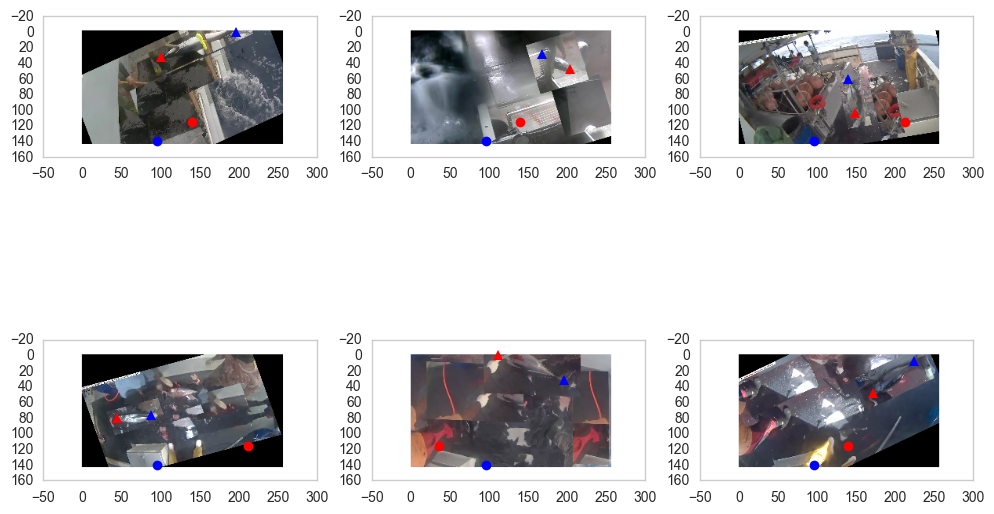

In [29]:
# TEST
# predict on sample generated images
return_type = 'coord'
gn_coord_fold_out = gen(df_coord_fold_out,return_type,batch_size=12,rng=np.random.RandomState(290615))
X,Y_true_enc = next(gn_coord_fold_out)
if return_type == 'coord':
    Y_pred_enc = m0_coord_cls.predict(X)
    Y_pred = decode_classification(Y_pred_enc)
    Y_true = decode_classification(Y_true_enc)
else:
    Y_pred = m0_contain.predict(X)
    Y_true = Y_true_enc

# plot sample
plt.figure(figsize=(12,16))
for i in range(bs):
    plt.subplot('43'+str(i+1))
    img = X[i,...]
    plt.imshow(img)
    if return_type == 'coord':
        plt.plot(Y_pred[i,0],Y_pred[i,1],'ro')
        plt.plot(Y_pred[i,2],Y_pred[i,3],'bo')
        plt.plot(Y_true[i,0],Y_true[i,1],'r^')
        plt.plot(Y_true[i,2],Y_true[i,3],'b^')
    else:
        plt.title('true: %d, pred: %.2f ' % (Y_true[i],Y_pred[i,0]))

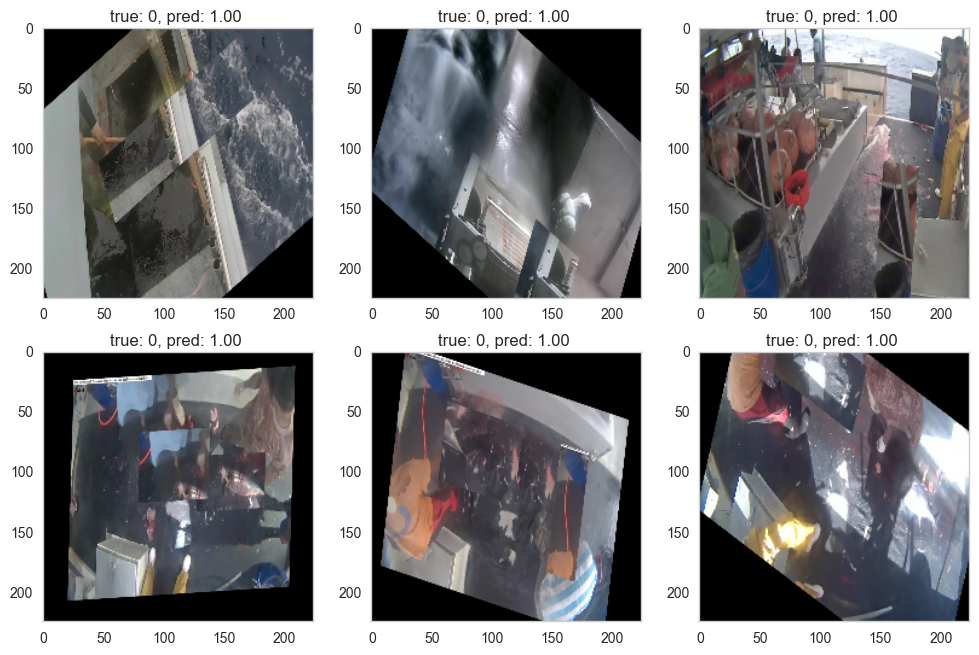

In [28]:
# predict on sample generated images
gn_coord_fold_out = gen(df_coord_fold_out,'contain',batch_size=12,rng=np.random.RandomState(290615))
X,Y_true = next(gn_coord_fold_out)
Y_pred = m0_coord_cls.predict(X)
X[:,:,:,0] += 123.68
X[:,:,:,1] += 116.779
X[:,:,:,2] += 103.939
plt.figure(figsize=(12,16))
for i in range(bs):
    plt.subplot('43'+str(i+1))
    img = X[i,...]
    plt.imshow(img)
    plt.title('true: %d, pred: %.2f ' % (Y_true[i],Y_pred[i,0]))